<a href="https://colab.research.google.com/github/nducduy/VBnote/blob/main/GMM_FaithFull.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#First, you'll need to mount your Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Next, we'll change the working directory to point to our Drive root directory.

In [3]:
%cd /content/drive/My\ Drive


/content/drive/My Drive


In [4]:
%%writefile vbgmm.py
#Credit: this code is adapted from the code written by https://github.com/vwrs
# -*- coding: utf-8 -*-
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import matplotlib as mpl


class VariationalGaussianMixture():
    """Variational Bayesian estimation of a Gaussian mixture."""

    def __init__(self, x, K):
        self.x = x
        self.N, self.D = x.shape
        self.K = K
        self.alpha0 = self.D + 1
        self.beta0 = self.D + 1
        self.nu0 = self.D + 1
        self.u0 = self._get_u0()
        self.V0 = self._get_V0()
        self._init_params()

    def _logdet(self, mat):
        (sign, logdet) = np.linalg.slogdet(mat)
        return logdet if sign == 1 else 0

    def _get_u0(self):
        return np.mean(self.x, axis=0)

    def _get_V0(self):
        diff = self.x - self.u0
        return np.linalg.inv(self.nu0 * diff.T.dot(diff) / self.N)

    def _init_u(self):
        cov = np.linalg.inv(self.nu0*self.V0) / self.beta0
        return np.random.multivariate_normal(self.u0, cov)

    def _init_params(self):
        self.alpha = np.tile(self.alpha0, self.K)
        self.beta = np.tile(self.beta0, self.K)
        self.nu = np.tile(self.nu0, self.K)
        self.u = np.array([self._init_u() for _ in range(self.K)])
        self.V = np.tile(self.V0, (self.K, 1, 1))

        self.rho = np.zeros((self.N, self.K))
        self.r = np.zeros((self.N, self.K))
        self.eta = np.zeros(self.K)

    def _update_rho(self, n, k):
        sum_digamma = np.sum([sp.digamma(0.5*(self.nu[k]+1-d))
                              for d in range(1, self.D+1)])
        diff = self.x[n, :] - self.u[k, :]

        self.rho[n, k] = np.exp(sp.digamma(self.alpha[k]) +
                                0.5*(sum_digamma +
                                     self._logdet(self.V[k, :]) -
                                     self.D/self.beta[k] - self.nu[k] *
                                     diff.dot(self.V[k, :]).dot(diff.T)
                                     )
                                )

    def _update_r(self, n, k):
        tmpsum = np.sum(self.rho[n, :])
        self.r[n, k] = self.rho[n, k] / tmpsum if tmpsum != 0 else 0

    def _update_eta(self, k):
        self.eta[k] = np.sum(self.r[:, k])

    def _update_alpha(self, k):
        self.alpha[k] = self.alpha0 + self.eta[k]

    def _update_beta(self, k):
        self.beta[k] = self.beta0 + self.eta[k]

    def _update_nu(self, k):
        self.nu[k] = self.nu0 + self.eta[k]

    def _update_u(self, k):
        self.u[k, :] = self.beta0*self.u0 + self.r[:, k].T.dot(self.x)
        self.u[k, :] /= self.beta[k]

    def _update_V(self, k):
        cov_sample = np.zeros_like(self.V0)
        diff_x = self.x - self.u[k]
        for n in range(self.N):
            cov_sample += self.r[n, k]*np.outer(diff_x[n, :], diff_x[n, :])
        diff = self.u[k] - self.u0

        self.V[k, :] = np.linalg.inv(
            np.linalg.inv(self.V0) +
            self.beta0 * np.outer(diff, diff) +
            cov_sample
        )

    def update_params(self):
        for k in range(self.K):
            for n in range(self.N):
                self._update_rho(n, k)
                self._update_r(n, k)
            self._update_eta(k)
            self._update_alpha(k)
            self._update_beta(k)
            self._update_nu(k)
            self._update_u(k)
            self._update_V(k)

    def fit(self, eps=1e-5, max_epochs=50, print_diff=False):
        epochs = 0
        while(True):
            eta_prev = self.eta.copy()
            self.update_params()
            #self._plot_with_ellipses1() #new line
            epochs += 1
            diff = np.linalg.norm(self.eta - eta_prev)
            if print_diff:
                print(diff)
            if (epochs > 5 and
                    (diff < eps or
                     np.abs(diff_prev - diff) < eps or
                     epochs >= max_epochs)):
                break
            diff_prev = diff
        print(f'# iterations: {epochs}')
        self.map_estimate()

    def map_estimate(self):
        self.w = np.zeros(self.K)
        self.means = self.u
        self.covs = np.zeros_like(self.V)
        for k in range(self.K):
            self.w[k] = self.alpha[k]/np.ones(self.K).dot(self.alpha)
            self.covs[k, :] = np.linalg.inv(self.nu[k] * self.V[k, :])
        print(f'w: {self.w}\nmeans: {self.means}\ncovs: {self.covs}')

    def kl_divergence(self):
        sum_kl = sp.gammaln(self.K*self.alpha0 + self.N) - \
            sp.gammaln(self.K*self.alpha0)
        tmp = self.r*np.log(self.r)
        tmp[np.isnan(tmp)] = 0
        sum_kl += np.sum(tmp)
        for k in range(self.K):
            sum_kl += (sp.gammaln(self.alpha0)-sp.gammaln(self.alpha[k]) +
                       sp.multigammaln(self.nu0*.5, self.D) -
                       sp.multigammaln(self.nu[k]*.5, self.D) +
                       0.5*(self._logdet(self.V0) * self.nu0 -
                            self._logdet(self.V[k, :])*self.nu[k] +
                       (np.log(self.beta[k])-np.log(self.beta0))*self.D))
        return sum_kl

    def _make_ellipses(self, k, ax):
        cov = self.covs[k, :]

        w, v = np.linalg.eigh(cov)
        # w: 2 eigenvalues (length), v: 2 eigenvectors (rotation)
        angle = np.degrees(np.arctan2(v[0, 1], v[0, 0]))
        height, width = 2 * np.sqrt(w)  # diameter = 2 * radius

        ell = mpl.patches.Ellipse(self.means[k, :], height, width,
                                  angle,
                                  fc='red', lw=0, alpha=.4)
        edge = mpl.patches.Ellipse(self.means[k, :], height, width,
                                   angle,
                                   fc='none', ec='red', lw=3)
        ax.add_artist(ell)
        ax.add_artist(edge)

    def plot_with_ellipses(self, figsize=(7, 7), dpi=200):
        fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
        ax.scatter(self.x[:, 0], self.x[:, 1],
                   c='green', edgecolor='black', alpha=.85)
        for k in range(self.K):
            self._make_ellipses(k, ax)
        ax.scatter(self.means[:, 0], self.means[:, 1],
                   c='red', edgecolor='k',
                   marker='.', s=150)
        plt.show()

    def _plot_with_ellipses1(self, figsize=(7, 7), dpi=200):
        fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
        ax.scatter(self.x[:, 0], self.x[:, 1],
                   c='green', edgecolor='black', alpha=.85)
        for k in range(self.K):
            self._make_ellipses(k, ax)
        ax.scatter(self.means[:, 0], self.means[:, 1],
                   c='red', edgecolor='k',
                   marker='.', s=150)
        plt.show()


def cluster_number_selection_by_kl(x, k_range, plot=False):
    kls = np.empty(len(k_range))
    for k in k_range:
        print(f'======= {k} =========')
        vgm = VariationalGaussianMixture(x, k)
        vgm.fit(print_diff=False)
        kls[k-1] = vgm.kl_divergence()
        if plot:
            vgm.plot_with_ellipses(figsize=(8, 5), dpi=100)

    argmin_k = np.argmin(kls) + 1
    print(f'argmin_k: {argmin_k}, min_kl: {kls[argmin_k]}')
    return kls, argmin_k


Overwriting vbgmm.py


In [5]:
#from google.colab import files
#src = list(files.upload().values())[0]
#open('vbgmm.py','wb').write(src)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from vbgmm import VariationalGaussianMixture, cluster_number_selection_by_kl

In [7]:
import pandas as pd
oldfaithFull = np.loadtxt('https://raw.githubusercontent.com/nducduy/VBnote/main/oldfaithful.txt', delimiter=',')


In [8]:
vgm = VariationalGaussianMixture(oldfaithFull, 2)
vgm.fit(max_epochs=50, print_diff=False)

# iterations: 34
w: [0.36462094 0.63537906]
means: [[ 2.10336418 55.33524558]
 [ 4.3020677  80.23024168]]
covs: [[[ 0.18435026  1.72388037]
  [ 1.72388037 48.00783976]]

 [[ 0.1916679   1.18200479]
  [ 1.18200479 39.06465028]]]


KL div: 897.9572604465675


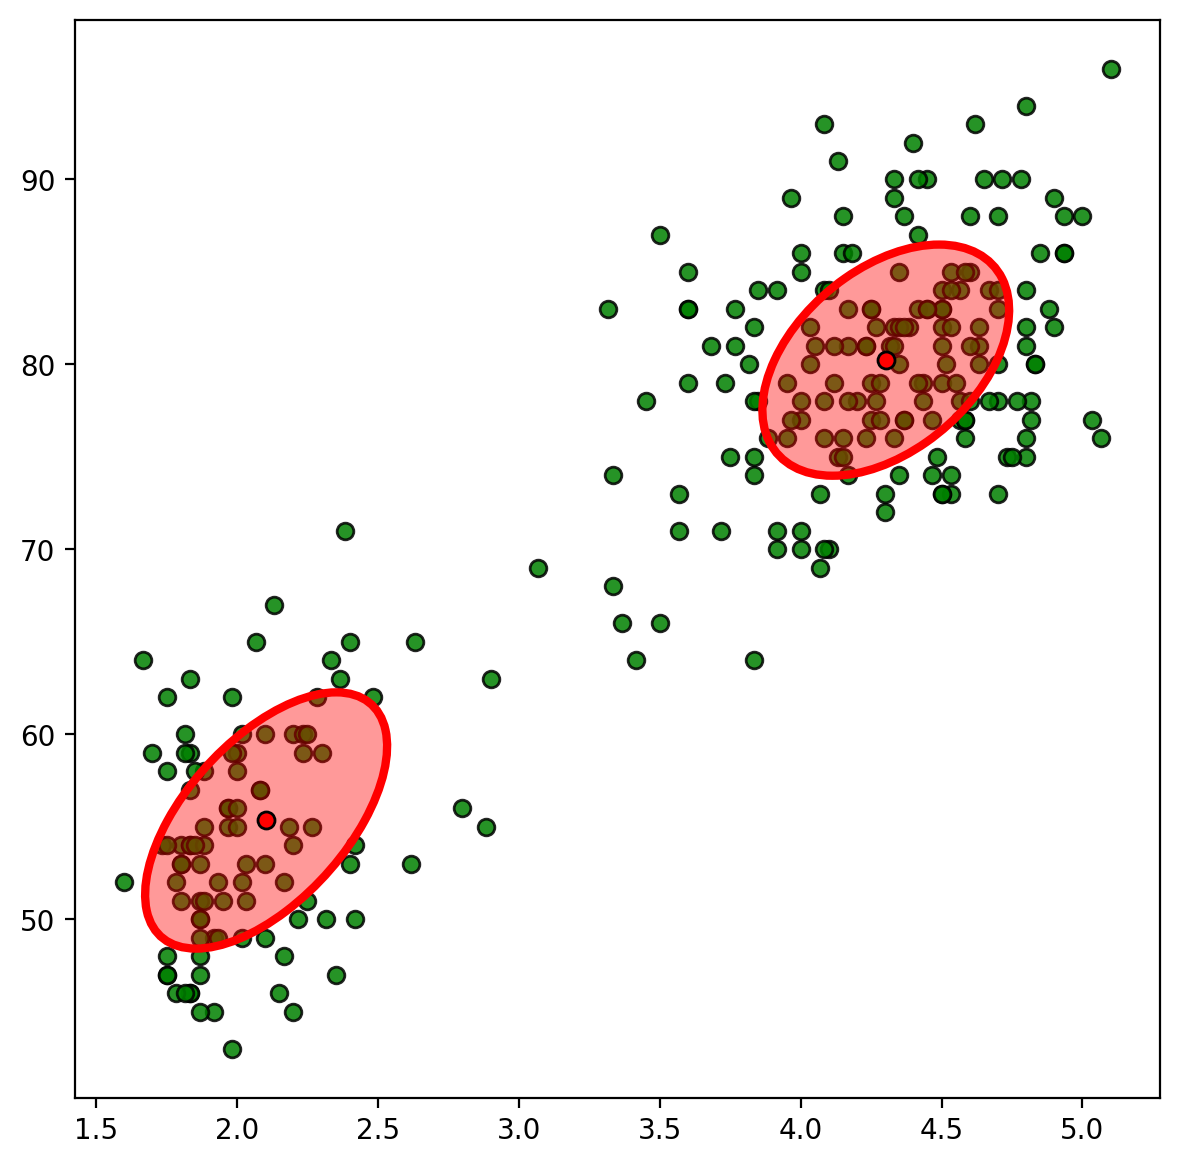

In [9]:
print(f'KL div: {vgm.kl_divergence()}')
vgm.plot_with_ellipses()

======= 1 =========
# iterations: 6
w: [1.]
means: [[ 3.48778309 70.89705882]]
covs: [[[  1.29793889  13.92641885]
  [ 13.92641885 184.14381488]]]


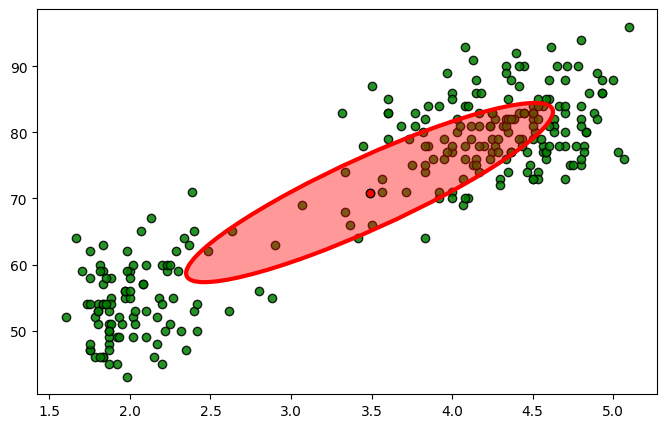

======= 2 =========
# iterations: 28
w: [0.36462094 0.63537906]
means: [[ 2.10336418 55.33524567]
 [ 4.3020677  80.23024161]]
covs: [[[ 0.18435026  1.7238804 ]
  [ 1.7238804  48.00784006]]

 [[ 0.19166789  1.18200477]
  [ 1.18200477 39.06465006]]]


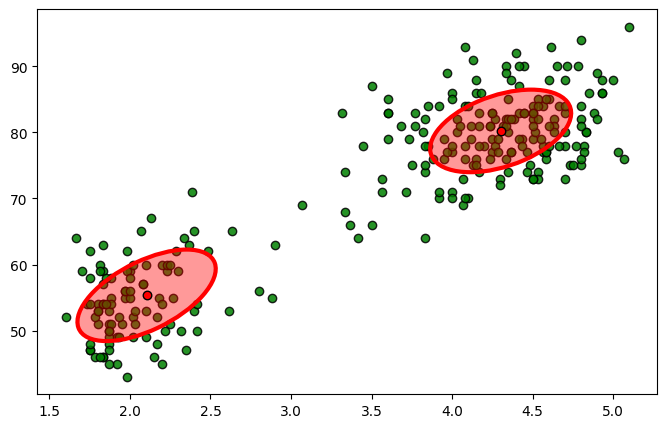

======= 3 =========
# iterations: 43
w: [0.625      0.35714286 0.01785714]
means: [[ 4.29151778 80.0097051 ]
 [ 2.11022611 55.54335873]
 [ 3.60576415 73.20783171]]
covs: [[[  0.18926497   1.14995166]
  [  1.14995166  38.51830869]]

 [[  0.18416824   1.72618819]
  [  1.72618819  48.25797145]]

 [[  1.13120398  12.38312841]
  [ 12.38312841 172.26777295]]]


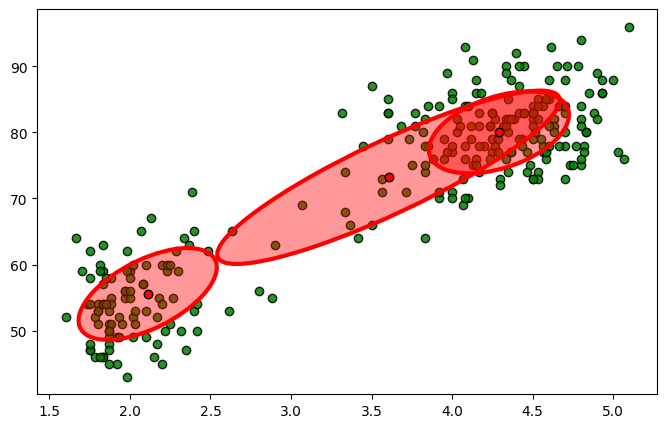

======= 4 =========
# iterations: 36
w: [0.35335689 0.01413428 0.61484099 0.01766784]
means: [[ 2.10132773 55.32705522]
 [ 3.82221995 78.05259383]
 [ 4.29357347 80.02159873]
 [ 3.60539163 73.21812068]]
covs: [[[1.82171849e-01 1.70269139e+00]
  [1.70269139e+00 4.78026307e+01]]

 [[1.32662333e+00 1.53564591e+01]
  [1.53564591e+01 2.27212561e+02]]

 [[1.88578163e-01 1.14258977e+00]
  [1.14258977e+00 3.83347767e+01]]

 [[1.12885530e+00 1.23290838e+01]
  [1.23290838e+01 1.71381173e+02]]]


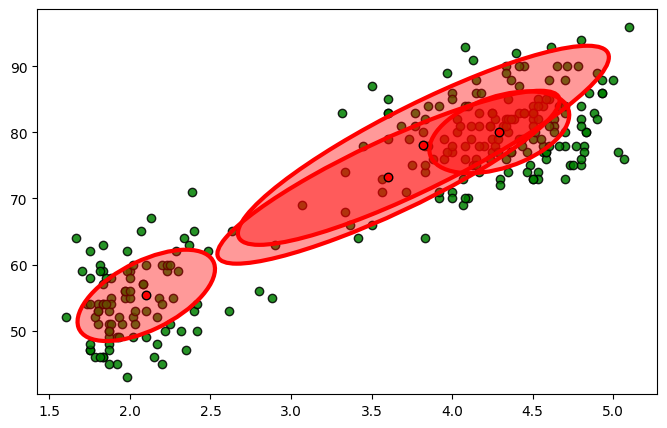

======= 5 =========
# iterations: 37
w: [0.6048951  0.34965035 0.01748252 0.01398601 0.01398601]
means: [[ 4.29567905 80.03388581]
 [ 2.09254894 55.11190304]
 [ 3.60482007 73.22767233]
 [ 3.8202833  78.03308676]
 [ 3.82028329 78.03308679]]
covs: [[[1.87864464e-01 1.13516334e+00]
  [1.13516334e+00 3.81524266e+01]]

 [[1.80391927e-01 1.68323170e+00]
  [1.68323170e+00 4.74316106e+01]]

 [[1.12704427e+00 1.22815568e+01]
  [1.22815568e+01 1.70584981e+02]]

 [[1.32499222e+00 1.53130925e+01]
  [1.53130925e+01 2.26438589e+02]]

 [[1.32499221e+00 1.53130924e+01]
  [1.53130924e+01 2.26438589e+02]]]


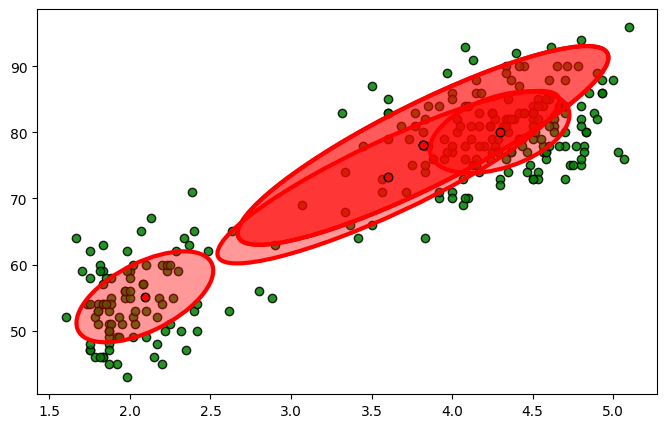

======= 6 =========
# iterations: 50
w: [0.34722222 0.01736111 0.01041667 0.01388889 0.59722222 0.01388889]
means: [[ 2.09426736 55.13519004]
 [ 3.61821244 73.47185992]
 [ 4.16005637 84.946671  ]
 [ 3.82035326 78.00792347]
 [ 4.30774445 80.23864319]
 [ 3.82220791 78.04562683]]
covs: [[[1.81936936e-01 1.69914588e+00]
  [1.69914588e+00 4.75622265e+01]]

 [[1.12444967e+00 1.22667992e+01]
  [1.22667992e+01 1.70917428e+02]]

 [[1.94272130e+00 2.58882104e+01]
  [2.58882104e+01 4.24806232e+02]]

 [[1.32313008e+00 1.52873196e+01]
  [1.52873196e+01 2.26081199e+02]]

 [[1.87408858e-01 1.12923218e+00]
  [1.12923218e+00 3.81128776e+01]]

 [[1.32493624e+00 1.53197205e+01]
  [1.53197205e+01 2.26673686e+02]]]


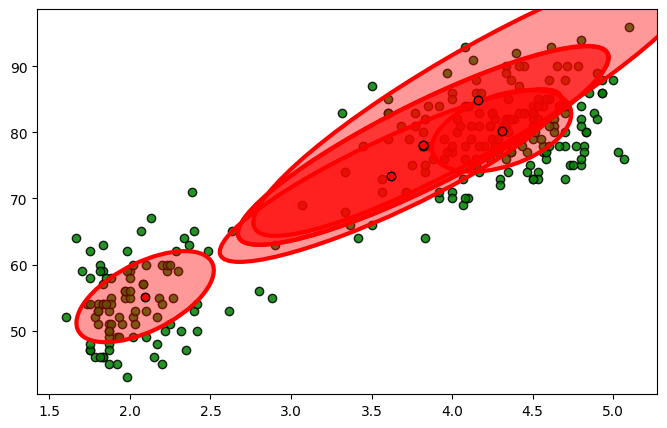

argmin_k: 2, min_kl: 906.950615971555


In [12]:
k_range = np.arange(1,7)
kls, argmin_k = cluster_number_selection_by_kl(oldfaithFull, k_range, plot=True)

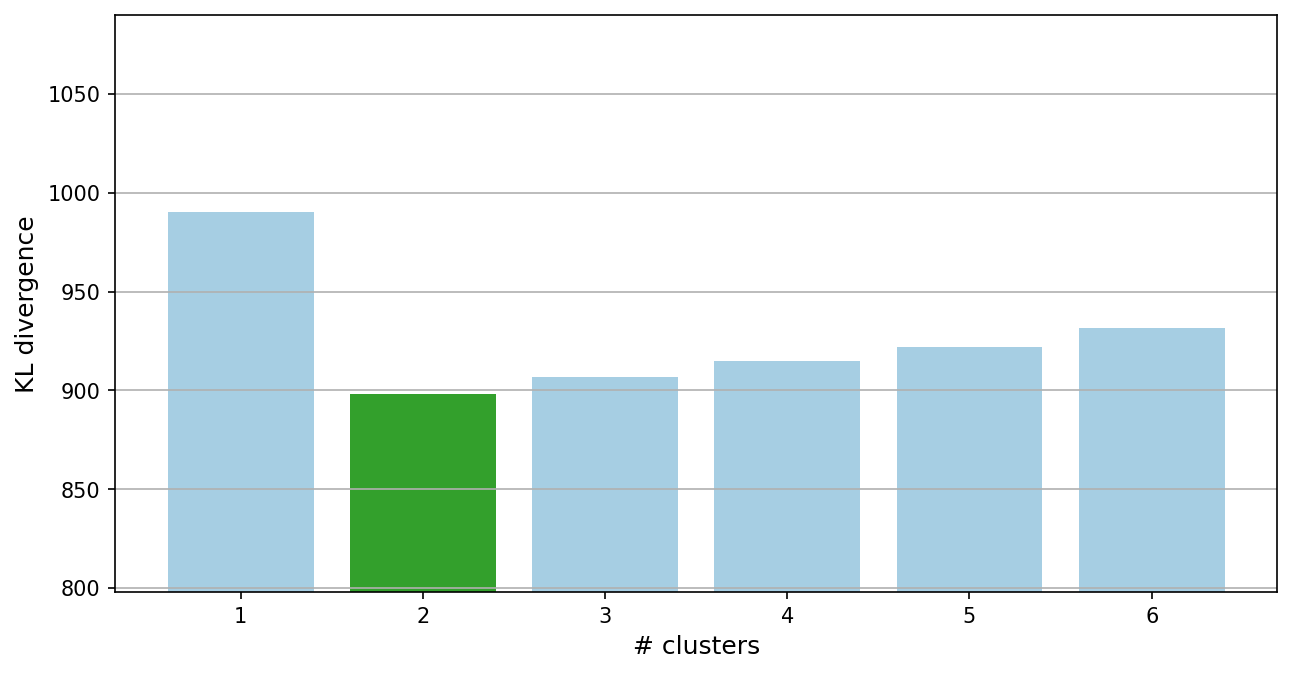

In [13]:
k_range_0 = k_range - 1
colors = plt.cm.Paired([0,3])

plt.figure(figsize=(10,5), dpi=150)
for k in k_range_0:
    g = 1 if k+1 == argmin_k else 0
    plt.bar(k, kls[k], color=colors[g])

plt.xticks(k_range_0, k_range)
plt.grid(axis='y')
plt.ylim(kls.min()-100, kls.max()+100)
plt.ylabel('KL divergence', fontsize=12)
plt.xlabel('# clusters', fontsize=12)
plt.show()